<a href="https://colab.research.google.com/github/PankajSanger/Oriserve---Intern-Data-Scientist-Assignment-/blob/main/Subtheme_Sentiment_Analysis_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Preprocessing data...
advisor agent service
1    388
0    163
Name: count, dtype: int64
balancing
0    24
1    14
Name: count, dtype: int64
booking confusion
0    119
1      1
Name: count, dtype: int64
call wait time
0    24
1     1
Name: count, dtype: int64
change of date
0    277
1     21
Name: count, dtype: int64
change of time
0    42
1     1
Name: count, dtype: int64
damage
0    126
Name: count, dtype: int64
delivery punctuality
1    448
0    250
Name: count, dtype: int64
discounts
1    113
0     36
Name: count, dtype: int64
ease of booking
1    1169
0     226
Name: count, dtype: int64
extra charges
1    83
0    46
Name: count, dtype: int64
facilities
1    33
0    18
Name: count, dtype: int64
failed payment
0    5
1    1
Name: count, dtype: int64
garage service
1    2015
0     423
Name: count, dtype: int64
incorrect tyres
0    70
1     2
Name: count, dtype: int64
late notice
0    76
1     1
Name: count, dtype: int64
length of fitting
1    645
0    108
Name: coun

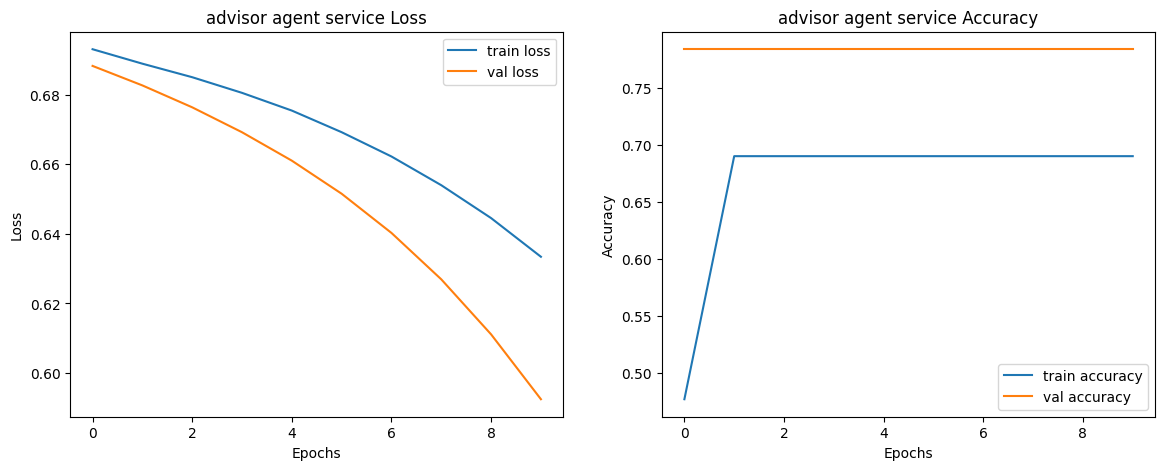

Plotting training history...


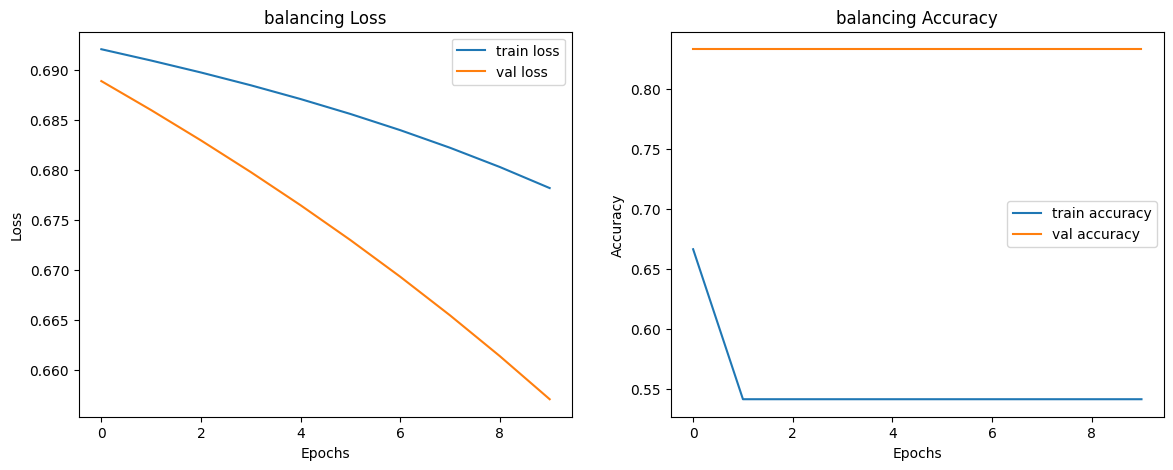

Plotting training history...


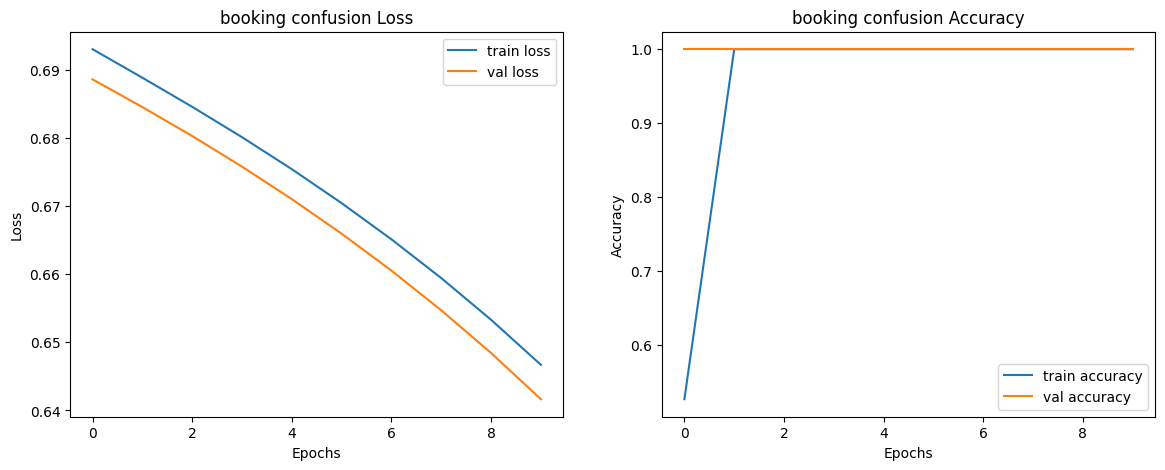

Plotting training history...


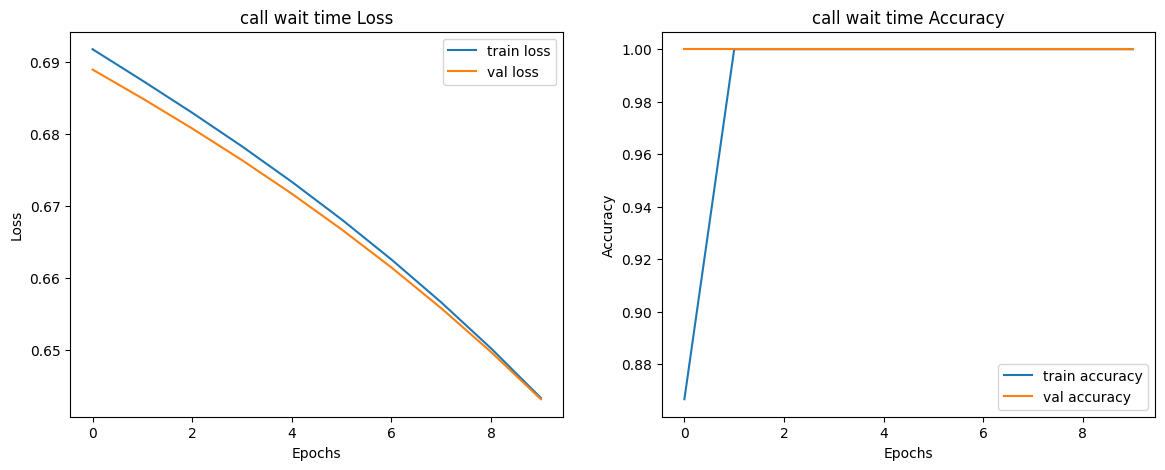

Plotting training history...


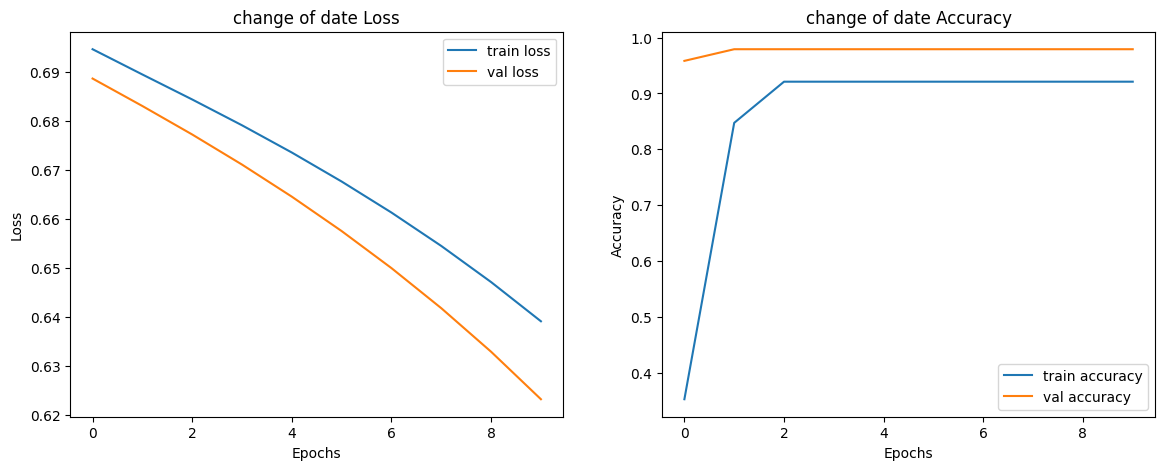

Plotting training history...


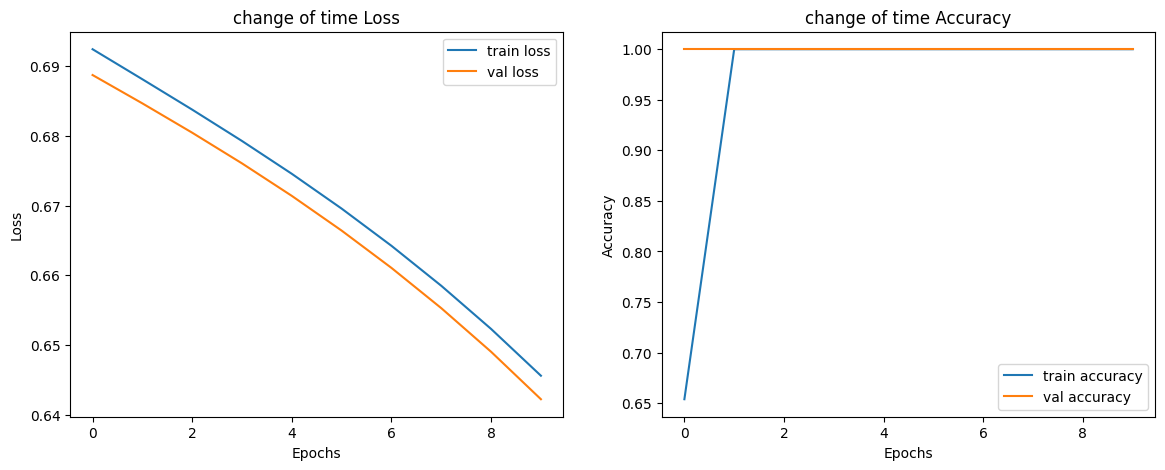

Plotting training history...


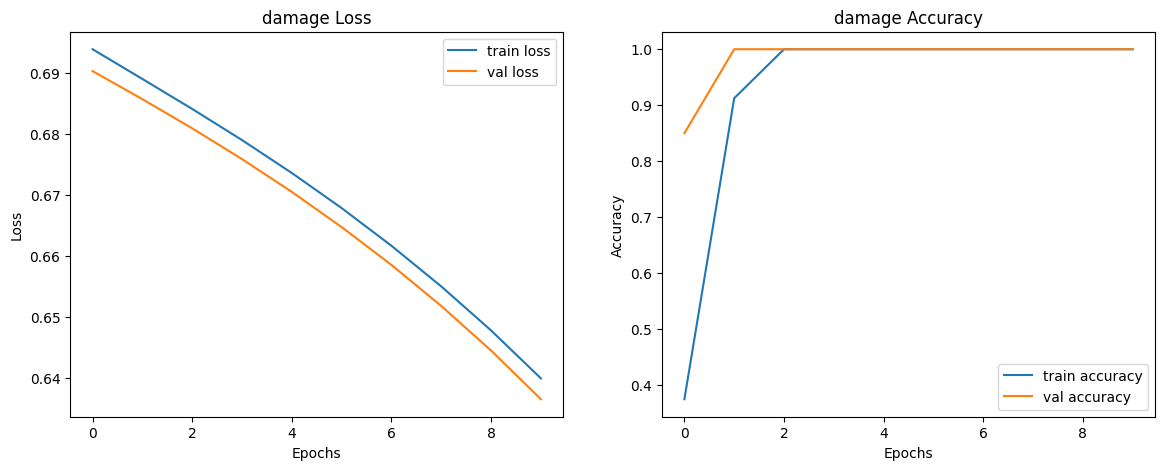

Plotting training history...


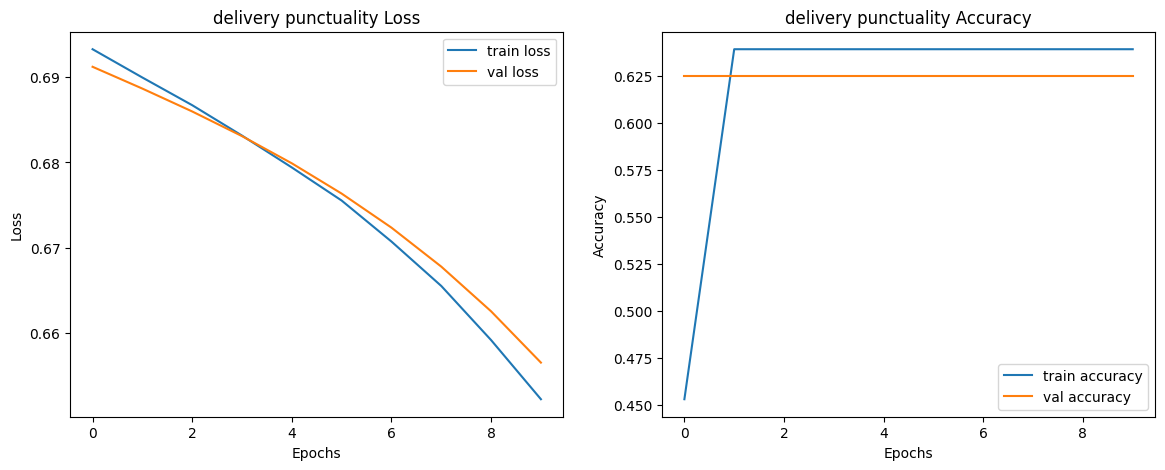

Plotting training history...


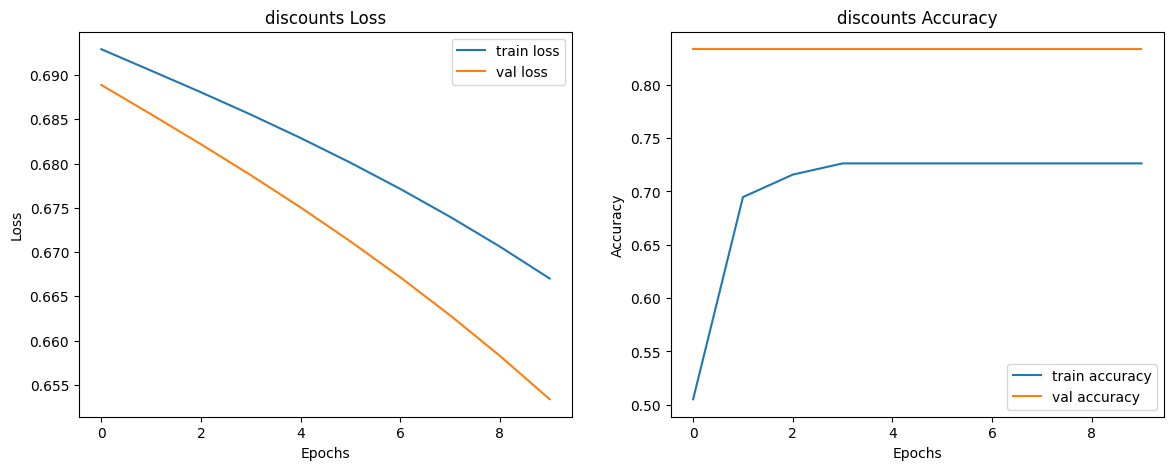

Plotting training history...


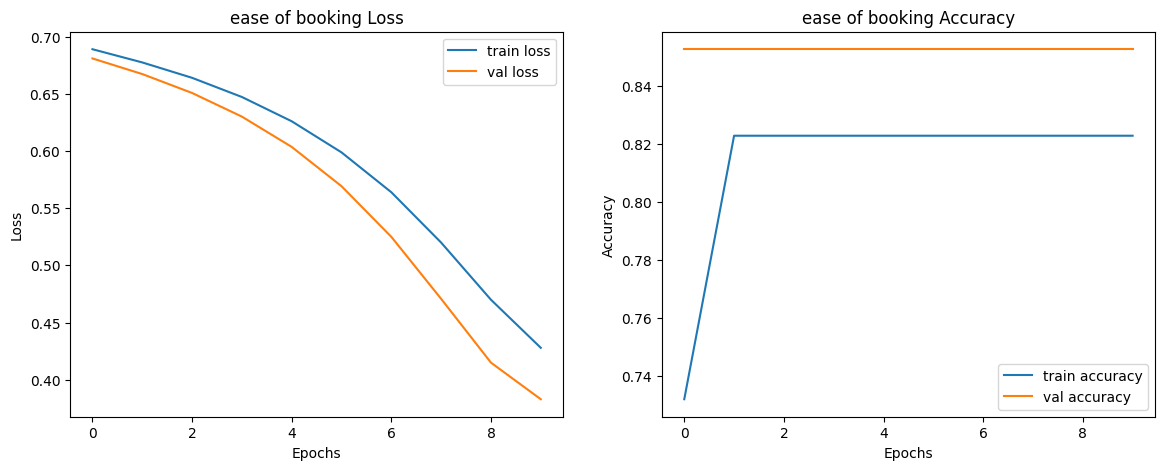

Plotting training history...


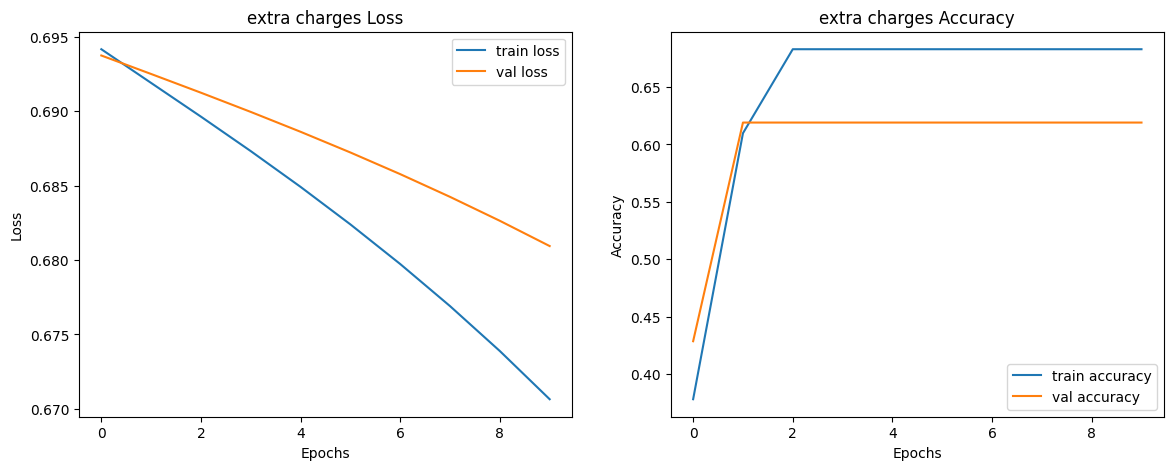

Plotting training history...


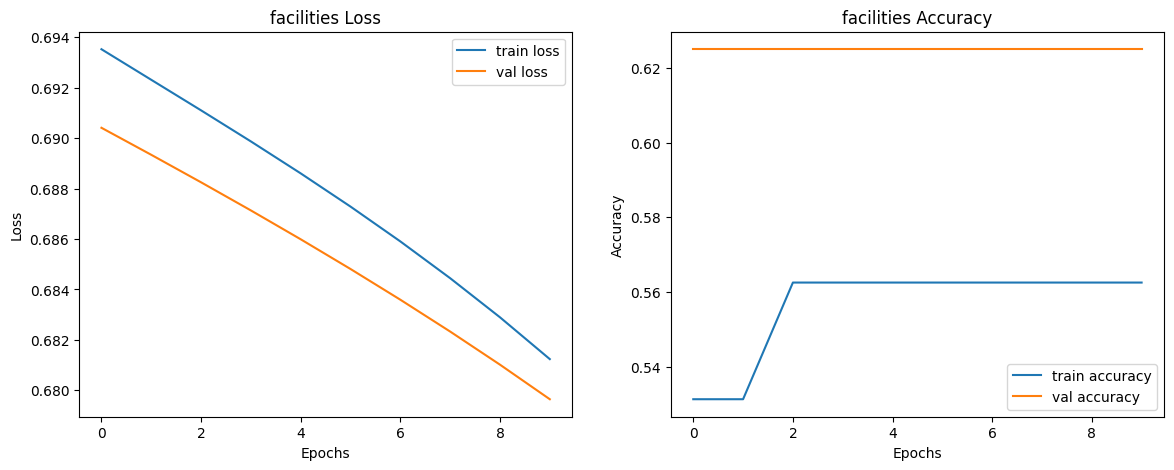

Plotting training history...


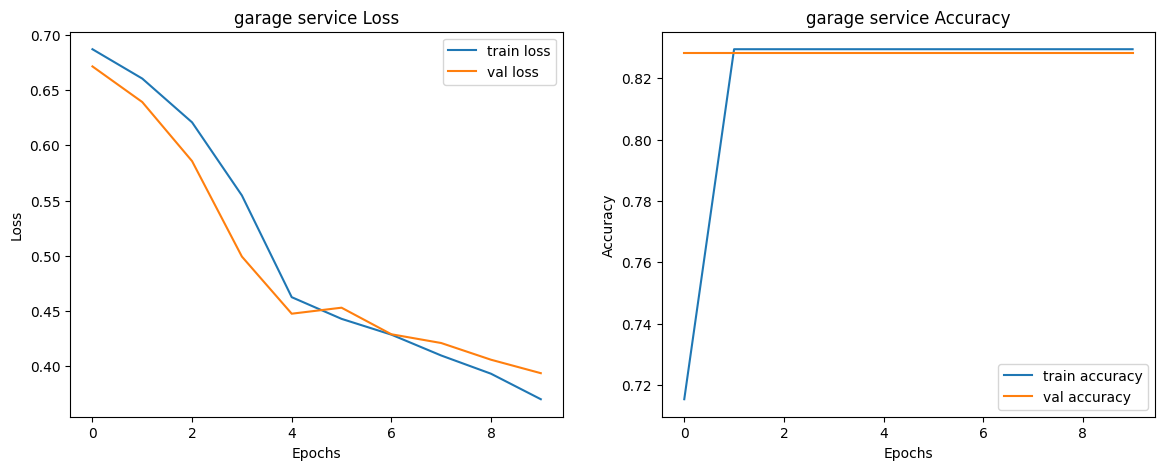

Plotting training history...


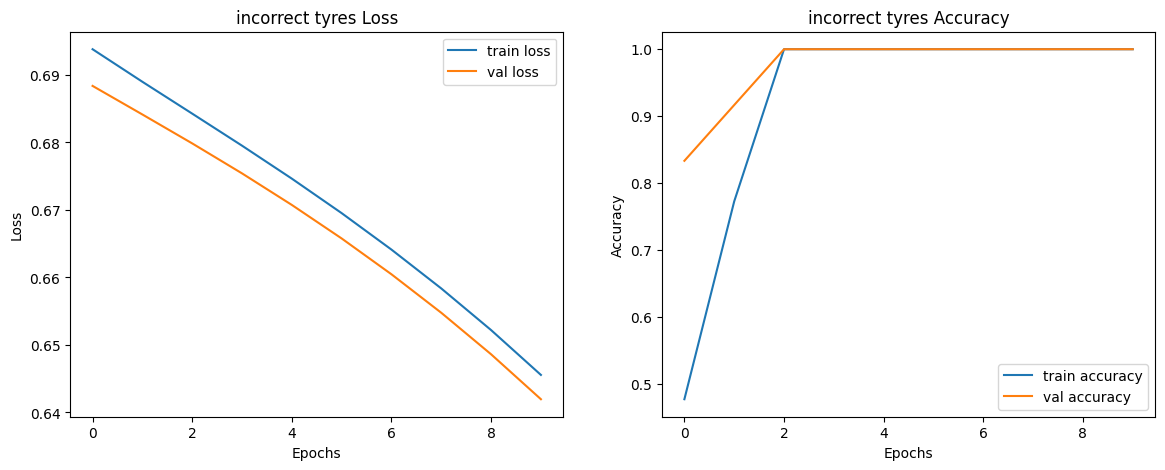

Plotting training history...


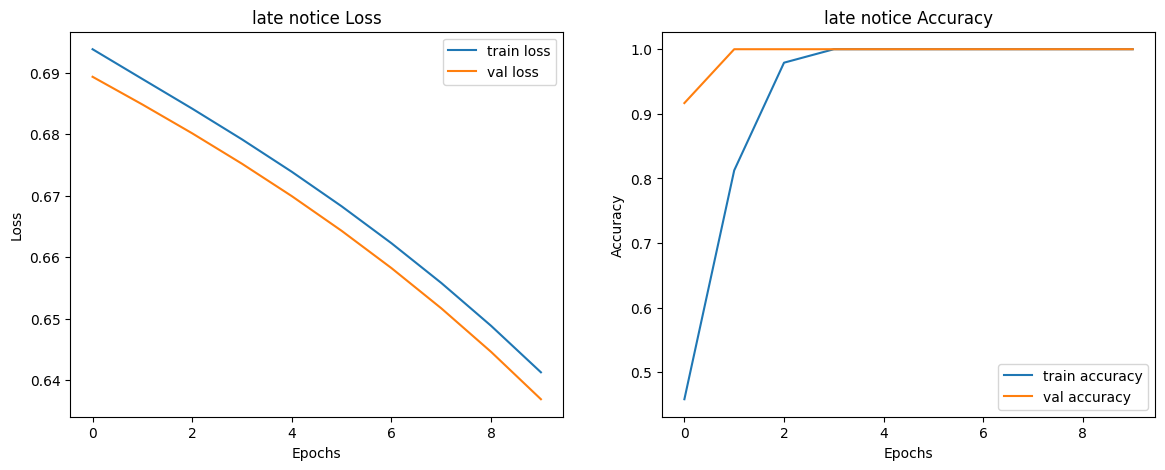

Plotting training history...


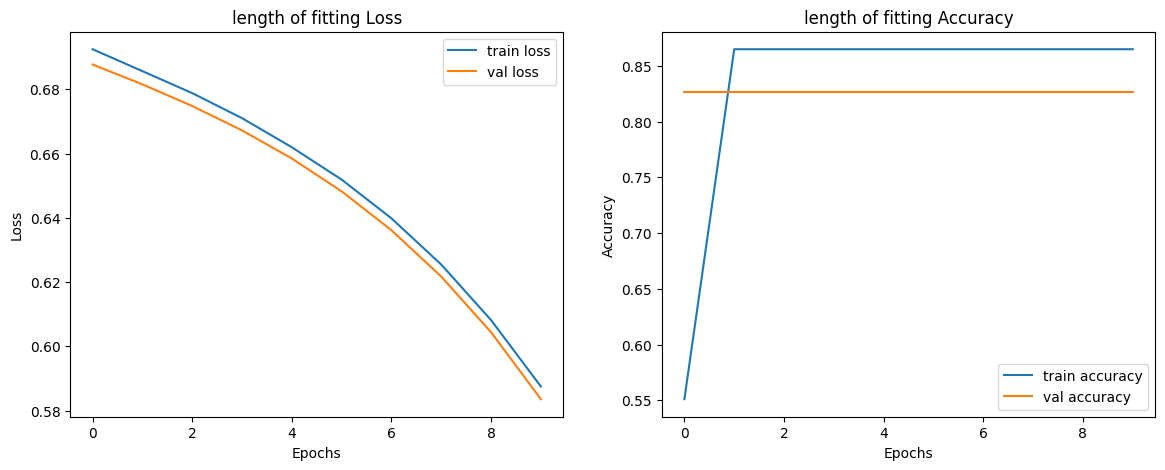

Plotting training history...


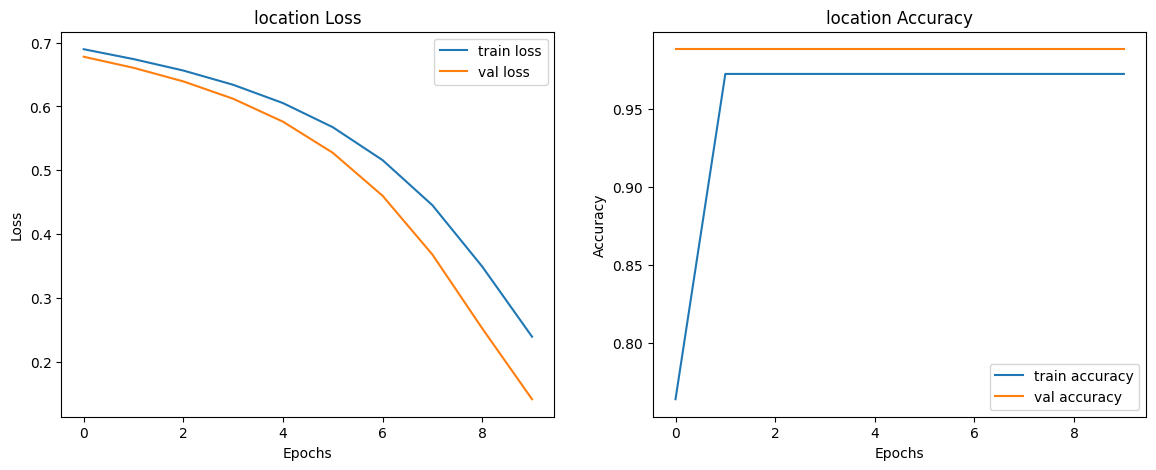

Plotting training history...


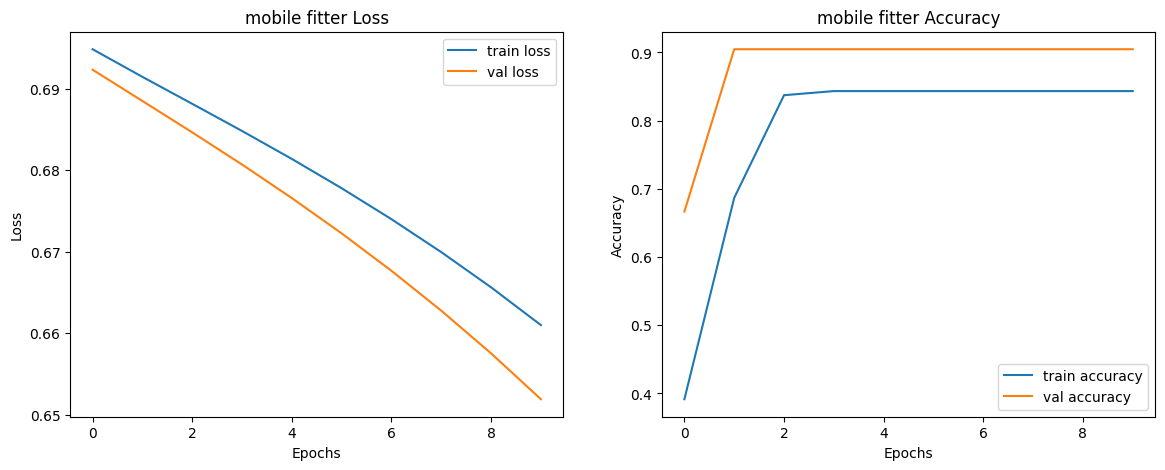

Plotting training history...


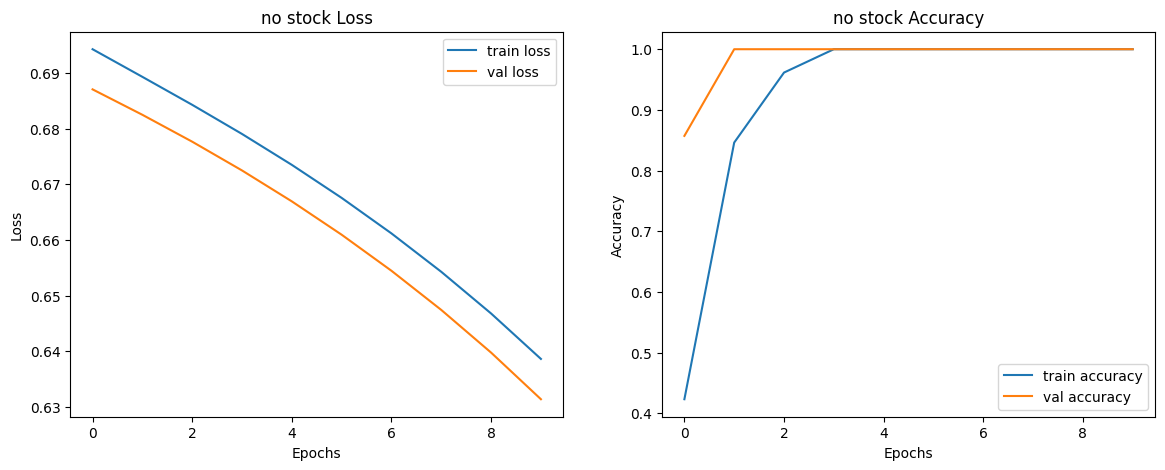

Plotting training history...


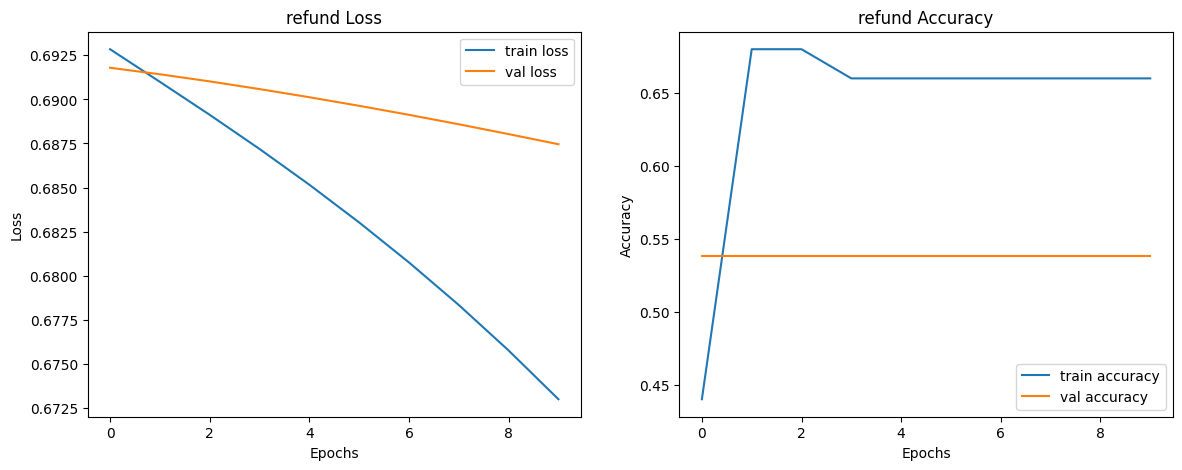

Plotting training history...


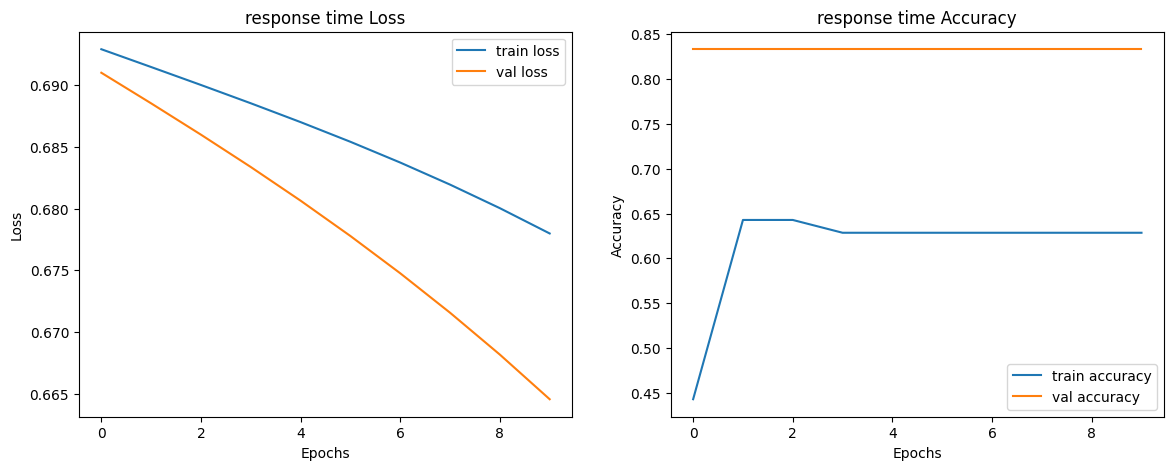

Plotting training history...


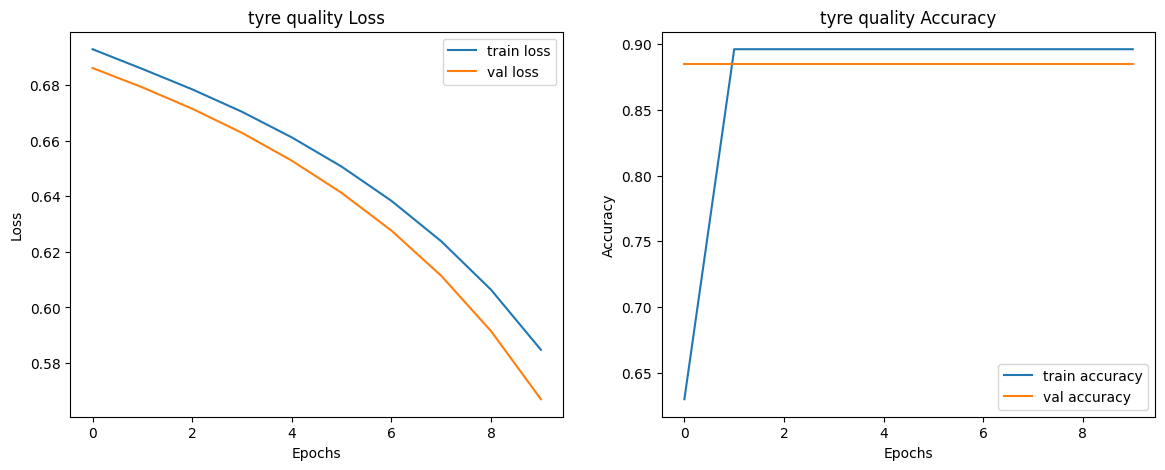

Plotting training history...


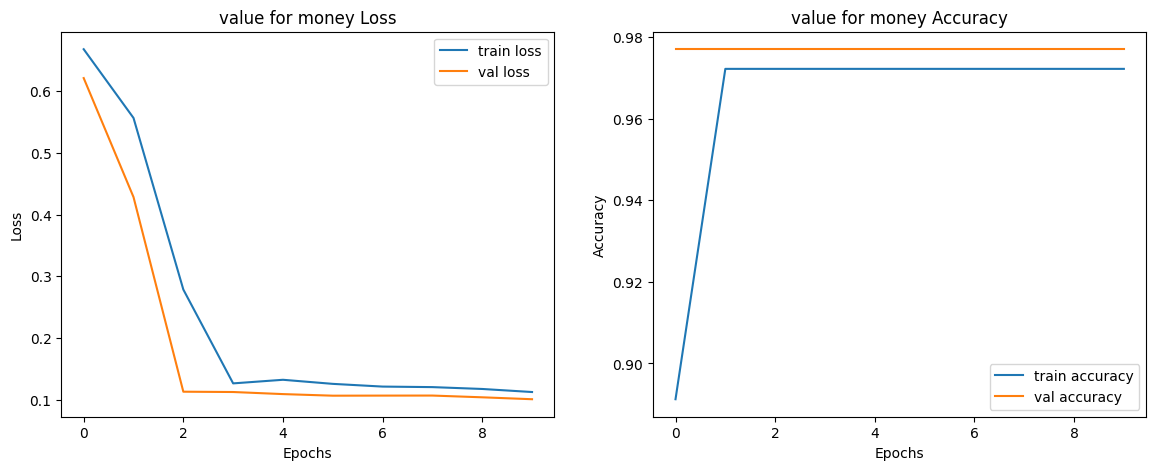

Plotting training history...


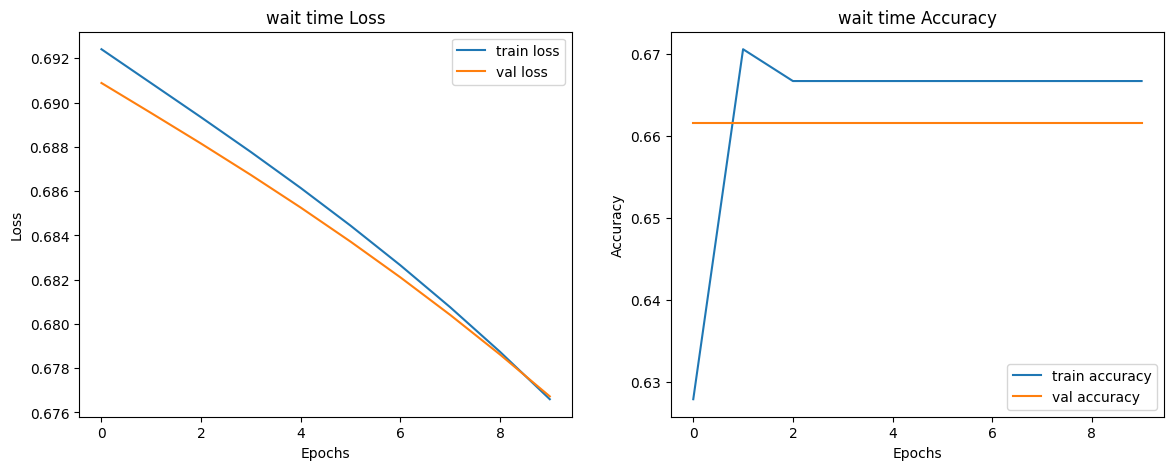

In [91]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
import matplotlib.pyplot as plt
import seaborn as sns

class MulticlassBinaryLSTM:
    def __init__(self, dataset_path):
        """
        Initialize MulticlassBinaryLSTM class.

        Parameters:
        dataset_path (str): Path to the dataset CSV file.
        """
        self.dataset_path = dataset_path
        self.dataset = None
        self.tokenizer = None
        self.models = []
        self.histories = []
        self.target_columns = []
        self.X_test = {}  # Dictionary to store X_test for each target column
        self.y_test = {}  # Dictionary to store y_test for each target column
        self.max_sequence_length = 15  # Define the padding length here

    def load_dataset(self):
        """Load the dataset from the specified CSV file."""
        print("Loading dataset...")
        self.dataset = pd.read_csv(self.dataset_path)

    def preprocess_data(self):
        """Preprocess the loaded dataset."""
        print("Preprocessing data...")
        # Extract unique sentiments
        unique_sentiments = self.dataset.iloc[:, 1:].values.flatten()
        unique_sentiments = list(set(unique_sentiments))

        # Filter sentiments with length between 10 and 50 characters
        filtered_sentiments = [s for s in unique_sentiments if 10 < len(str(s)) <= 50]
        filtered_sentiments.sort()

        # Create DataFrame from filtered sentiments
        dataframe = pd.DataFrame(filtered_sentiments)

        column_list = pd.read_csv("/content/Book2.csv")
        nested_dict = column_list.groupby(['3', '2'])['1'].apply(list).unstack().apply(lambda x: x.dropna().to_dict()).to_dict()
        unique_column_names = column_list["2"].unique()

        for column_name in unique_column_names:
            self.dataset[column_name] = None

            if column_name in nested_dict:
                for index, row in self.dataset.iterrows():
                    for nested_key in nested_dict[column_name]:
                        if any(item in row.values for item in nested_dict[column_name][nested_key]):
                            self.dataset.at[index, column_name] = nested_key
                            break

        columns_to_drop = ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11", "s12", "s13", "s14"]
        self.dataset = self.dataset.drop(columns=columns_to_drop)
        self.dataset = self.dataset.dropna(subset=unique_column_names, how='all')

        for i in unique_column_names:
            print(self.dataset[i].value_counts())

        columns_to_process = {
            'booking confusion': [1],
            'call wait time': [1],
            'change of time': [1],
            'failed payment': [0, 1],
            'incorrect tyres': [1],
            'late notice': [1],
            'no stock': [1]
        }

        for column_name, values_to_replace in columns_to_process.items():
            self.dataset = self.process_column(self.dataset, column_name, values_to_replace)

        # Drop the 'failed payment' column
        self.dataset.drop(columns='failed payment', inplace=True)

        check = self.dataset.drop(columns="Text")
        self.target_columns = check.columns

    def process_column(self, df, column_name, values_to_replace):
        """
        Process a specific column in the dataset by replacing values.

        Parameters:
        df (DataFrame): DataFrame containing the dataset.
        column_name (str): Name of the column to process.
        values_to_replace (list): Values to replace in the column.

        Returns:
        DataFrame: Processed DataFrame.
        """
        # Convert Series to DataFrame
        df_column = pd.DataFrame({column_name: df[column_name]})
        df_column[column_name] = df_column[column_name].replace(to_replace=values_to_replace, value=None)
        # Assign back to the original DataFrame
        df[column_name] = df_column[column_name]

        return df

    def preprocess_text(self, text):
        """
        Preprocess a given text.

        Parameters:
        text (str): Input text to preprocess.

        Returns:
        str: Preprocessed text.
        """
        print("Preprocessing text...")
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Correct spelling
        text = str(TextBlob(text).correct())
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        words = [word for word in words if word.lower() not in stop_words]
        text = ' '.join(words)
        # Lemmatization
        nlp = spacy.load('en_core_web_sm')
        doc = nlp(text)
        text = ' '.join([token.lemma_ for token in doc])
        return text

    def tokenize_sequences(self):
        """Tokenize sequences in the dataset."""
        print("Tokenizing sequences...")
        self.tokenizer = Tokenizer(num_words=4300)
        texts = self.dataset['Text'].values
        self.tokenizer.fit_on_texts(texts)
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_sequence_length, padding='post', truncating='post')

        return padded_sequences

    def create_and_train_lstm_model(self, X_train, y_train):
        """
        Create and train an LSTM model.

        Parameters:
        X_train (array): Training data.
        y_train (array): Target labels for training data.

        Returns:
        model: Trained LSTM model.
        history: Training history of the model.
        """
        print("Creating and training LSTM model...")
        model = Sequential()
        model.add(Embedding(input_dim=4300, output_dim=12, input_length=self.max_sequence_length))  # Use the defined max_sequence_length
        model.add(LSTM(32))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=10, batch_size=300, validation_split=0.2)  # Increased epochs to 10
        return model, history

    def train_models(self):
        """Train LSTM models for each target column."""
        print("Training models...")
        X = self.tokenize_sequences()

        for column in self.target_columns:
            # Filter out rows with NaN values in both the text column and the target column
            filtered_dataset = self.dataset.dropna(subset=['Text', column])
            y = filtered_dataset[column].values.astype(float)
            X_train, X_test, y_train, y_test = train_test_split(filtered_dataset['Text'], y, test_size=0.2, random_state=42)

                        # Assign y_test to self.y_test dictionary
            self.y_test[column] = y_test

            # Tokenize and pad sequences for X_train and X_test
            X_train_seq = self.tokenizer.texts_to_sequences(X_train)
            X_test_seq = self.tokenizer.texts_to_sequences(X_test)
            X_train_pad = pad_sequences(X_train_seq, maxlen=self.max_sequence_length, padding='post', truncating='post')
            X_test_pad = pad_sequences(X_test_seq, maxlen=self.max_sequence_length, padding='post', truncating='post')

            # Assign X_test_pad to self.X_test dictionary
            self.X_test[column] = X_test_pad

            print(X_train_pad.shape, X_test_pad.shape, y_train.shape, y_test.shape)
            model, history = self.create_and_train_lstm_model(X_train_pad, y_train)
            self.models.append((column, model))
            self.histories.append((column, history))

    def generate_predictions(self, X_data):
        """
        Generate predictions for given data.

        Parameters:
        X_data (dict): Dictionary containing data for each target column.

        Returns:
        dict: Predictions for each target column.
        """
        print("Generating predictions...")
        predictions = {}
        for column, model in self.models:
            X_test_pad = self.X_test[column]
            preds = model.predict(X_test_pad).flatten()
            predictions[column] = preds
        print("Predictions generated.")
        return predictions

    def binarize_predictions(self, predictions, threshold=0.5):
        """
        Binarize predictions based on a threshold.

        Parameters:
        predictions (dict): Predictions for each target column.
        threshold (float): Threshold for binarization.

        Returns:
        dict: Binarized predictions for each target column.
        """
        print("Binarizing predictions...")
        return {column: (pred >= threshold).astype(int) for column, pred in predictions.items()}

    def calculate_accuracy(self, y_true, y_pred):
        """
        Calculate accuracy.

        Parameters:
        y_true (array): True labels.
        y_pred (array): Predicted labels.

        Returns:
        float: Accuracy score.
        """
        print("Calculating accuracy...")
        accuracy = accuracy_score(y_true, y_pred)
        return accuracy

    def evaluate_models(self):
        """Evaluate trained models."""
        print("Evaluating models...")
        predictions = self.generate_predictions(self.X_test)
        binary_predictions = self.binarize_predictions(predictions)
        accuracies = {}
        for column, model in self.models:
            true_values = self.y_test[column]
            pred_values = binary_predictions[column]
            accuracy = self.calculate_accuracy(true_values, pred_values)
            accuracies[column] = accuracy
            print(f"Accuracy for {column}: {accuracy}")

        for column_name, history in self.histories:
            self.plot_history(history, column_name)

    def plot_history(self, history, column_name):
        """
        Plot training history.

        Parameters:
        history: Training history of the model.
        column_name (str): Name of the target column.
        """
        print("Plotting training history...")
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.title(f'{column_name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='train accuracy')
        plt.plot(history.history['val_accuracy'], label='val accuracy')
        plt.title(f'{column_name} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

def main():
    dataset_path = "/content/Evaluation-dataset.csv"
    lstm_model = MulticlassBinaryLSTM(dataset_path)
    lstm_model.load_dataset()
    lstm_model.preprocess_data()
    lstm_model.train_models()
    lstm_model.evaluate_models()

if __name__ == "__main__":
    main()
